<a href="https://colab.research.google.com/github/Ruck13/Uczenie-maszynowe-w-finansach/blob/main/Case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Liczba filmów Sci-Fi: 4907


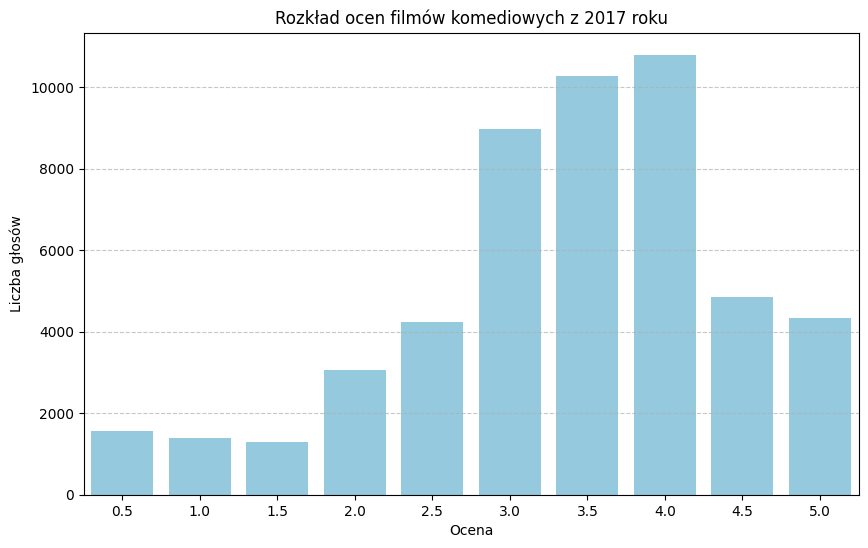

Średnia ocen wszystkich filmów akcji: 3.48
Najczęściej oceniane filmy akcji:
title
Matrix, The (1999)                           93808
Star Wars: Episode IV - A New Hope (1977)    85010
Fight Club (1999)                            77332
Name: rating, dtype: int64


In [ ]:
#Zadanie 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

movies_path = '/content/drive/MyDrive/uczenie/movies.csv'
ratings_path = '/content/drive/MyDrive/uczenie/ratings.csv'

try:
    movies = pd.read_csv(movies_path)
    ratings = pd.read_csv(ratings_path)
except FileNotFoundError:
    print("Błąd")
    raise


scifi_movies = movies[movies['genres'].str.contains('Sci-Fi', na=False)]
print(f"Liczba filmów Sci-Fi: {len(scifi_movies)}")


movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

comedy_2017 = movies[
    (movies['genres'].str.contains('Comedy', na=False)) &
    (movies['year'] == '2017')
]

comedy_2017_ratings = pd.merge(comedy_2017, ratings, on='movieId', how='inner')

if not comedy_2017_ratings.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='rating', data=comedy_2017_ratings, color='skyblue')
    plt.title('Rozkład ocen filmów komediowych z 2017 roku')
    plt.xlabel('Ocena')
    plt.ylabel('Liczba głosów')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Brak danych o ocenach dla komedii z 2017 roku ")

action_movies = movies[movies['genres'].str.contains('Action', na=False)]

action_ratings = pd.merge(action_movies, ratings, on='movieId', how='inner')

if not action_ratings.empty:
    avg_action_rating = action_ratings['rating'].mean()
    print(f"Średnia ocen wszystkich filmów akcji: {avg_action_rating:.2f}")

    top_3_action = action_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(3)

    print("Najczęściej oceniane filmy akcji:")
    print(top_3_action)
else:
    print("Brak danych")

In [ ]:
#Zadanie2

!pip install "numpy<2"
!pip install scikit-surprise

import os
import tempfile
import pandas as pd
import numpy as np
from collections import Counter
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

ratings_path = '/content/drive/MyDrive/uczenie/ratings.csv'

tmp_dir = tempfile.gettempdir()
temp_filtered_movies = os.path.join(tmp_dir, "ratings_filtered_movies.csv")
temp_filtered_final = os.path.join(tmp_dir, "ratings_filtered_final.csv")

use_cols = ['userId', 'movieId', 'rating']
chunksize = 300_000


movie_counter = Counter()
for chunk in pd.read_csv(ratings_path, usecols=['movieId'], chunksize=chunksize):
    movie_counter.update(chunk['movieId'].values)

min_movie_ratings = 50
popular_movies = {mid for mid, c in movie_counter.items() if c >= min_movie_ratings}
print("Liczba popularnych filmów:", len(popular_movies))


user_counter = Counter()
with open(temp_filtered_movies, 'w', encoding='utf-8') as fout:
    fout.write(','.join(use_cols) + '\n')
    for chunk in pd.read_csv(ratings_path, usecols=use_cols, chunksize=chunksize):
        mask = chunk['movieId'].isin(popular_movies)
        if not mask.any():
            continue
        sub = chunk.loc[mask, use_cols]
        sub['userId'] = pd.to_numeric(sub['userId'], downcast='integer')
        sub['movieId'] = pd.to_numeric(sub['movieId'], downcast='integer')
        sub['rating'] = pd.to_numeric(sub['rating'], downcast='float')
        user_counter.update(sub['userId'].values)
        sub.to_csv(fout, header=False, index=False)

min_user_ratings = 20
active_users = {uid for uid, c in user_counter.items() if c >= min_user_ratings}
print("Liczba aktywnych użytkowników po filtrze filmów:", len(active_users))


with open(temp_filtered_final, 'w', encoding='utf-8') as fout:
    fout.write(','.join(use_cols) + '\n')
    for chunk in pd.read_csv(temp_filtered_movies, usecols=use_cols, chunksize=chunksize):
        mask = chunk['userId'].isin(active_users)
        if not mask.any():
            continue
        sub = chunk.loc[mask, use_cols]
        # ponownie downcast (dla bezpieczeństwa)
        sub['userId'] = pd.to_numeric(sub['userId'], downcast='integer')
        sub['movieId'] = pd.to_numeric(sub['movieId'], downcast='integer')
        sub['rating'] = pd.to_numeric(sub['rating'], downcast='float')
        sub.to_csv(fout, header=False, index=False)


ratings_small = pd.read_csv(temp_filtered_final)
print("Ostateczna liczba ocen:", len(ratings_small))
print("Unikalnych userId:", ratings_small['userId'].nunique())
print("Unikalnych movieId:", ratings_small['movieId'].nunique())

max_rows = 200_000
if len(ratings_small) > max_rows:
    ratings_small = ratings_small.sample(n=max_rows, random_state=42).reset_index(drop=True)



reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_small[['userId', 'movieId', 'rating']], reader)


k_values = [2, 3, 4]
best = {'rmse': float('inf'), 'k': None, 'results': None}

sim_options = {'name': 'pearson', 'user_based': False}

for k in k_values:
    print(f"Testuję KNNBasic z k={k} ...")
    algo = KNNBasic(k=k, sim_options=sim_options, verbose=False)
    res = cross_validate(algo, data, measures=['RMSE'], cv=2, verbose=False, n_jobs=1)
    mean_rmse = np.mean(res['test_rmse'])
    print(f"  mean RMSE (cv=2) = {mean_rmse:.4f}")
    if mean_rmse < best['rmse']:
        best.update({'rmse': mean_rmse, 'k': k, 'results': res})

print("Najlepszy k:", best['k'], "z RMSE:", best['rmse'])

algo_svd = SVD()
cv_svd = cross_validate(algo_svd, data, measures=['RMSE', 'MAE'], cv=2, verbose=True, n_jobs=1)
print("SVD done.")

try:
    os.remove(temp_filtered_movies)
    os.remove(temp_filtered_final)
except Exception:
    pass


Liczba popularnych filmów: 16034
Liczba aktywnych użytkowników po filtrze filmów: 200559
Ostateczna liczba ocen: 31491808
Unikalnych userId: 200559
Unikalnych movieId: 16034
Zredukowano losowo do 200000 wierszy, żeby zmieścić się w RAM
Testuję KNNBasic z k=2 ...
  mean RMSE (cv=2) = 1.0572
Testuję KNNBasic z k=3 ...
  mean RMSE (cv=2) = 1.0572
Testuję KNNBasic z k=4 ...
  mean RMSE (cv=2) = 1.0572
Najlepszy k: 4 z RMSE: 1.057190490177501
Evaluating RMSE, MAE of algorithm SVD on 2 split(s).

                  Fold 1  Fold 2  Mean    Std     
RMSE (testset)    0.9710  0.9739  0.9724  0.0014  
MAE (testset)     0.7499  0.7524  0.7511  0.0012  
Fit time          1.77    1.82    1.80    0.02    
Test time         0.59    0.57    0.58    0.01    
SVD done.


In [ ]:
#Zadanie3
!pip install scikit-surprise

import pandas as pd
from surprise import Dataset, Reader, KNNBaseline

movies_path = '/content/drive/MyDrive/uczenie/movies.csv'
ratings_path = '/content/drive/MyDrive/uczenie/ratings.csv'

try:
    movies = pd.read_csv(movies_path)
    ratings = pd.read_csv(ratings_path)
except FileNotFoundError:
    print("Błąd")
    raise

targets = ["Penguins of Madagascar", "Hobbit: The Desolation of Smaug"]
target_ids = []

for t in targets:
    found = movies[movies['title'].str.contains(t, case=False, na=False)]
    if not found.empty:
        target_ids.extend(found['movieId'].tolist())

top_1000_ids = ratings['movieId'].value_counts().head(1000).index.tolist()

allowed_ids = list(set(top_1000_ids + target_ids))

ratings_filtered = ratings[ratings['movieId'].isin(allowed_ids)].copy()

print(f"Analiza obejmie {len(allowed_ids)} filmów (zamiast całej bazy).")
print(f"Liczba ocen po filtracji: {len(ratings_filtered)}")

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_filtered[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

sim_options = {
    'name': 'pearson_baseline',
    'user_based': False
}

print("\Trenowanie modelu ")
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

# 5. Generowanie rekomendacji
def get_movie_title(mid):
    return movies[movies['movieId'] == mid]['title'].values[0]

print("Wyniki rekomendacji")

for name in targets:
    match = movies[movies['title'].str.contains(name, case=False, na=False)]

    if not match.empty:
        real_id = match.iloc[0]['movieId']
        real_title = match.iloc[0]['title']
        print(f"\nJeśli obejrzałeś: '{real_title}'")

        try:
            inner_id = algo.trainset.to_inner_iid(real_id)

            neighbors = algo.get_neighbors(inner_id, k=5)

            print("Może Ci się spodobać:")
            for neighbor_inner in neighbors:
                neighbor_raw = algo.trainset.to_raw_iid(neighbor_inner)
                print(f" -> {get_movie_title(neighbor_raw)}")

        except ValueError:
            print("Ten film miał za mało ocen w analizowanej próbie, żeby znaleźć podobieństwa")


<>:43: SyntaxWarning: invalid escape sequence '\T'
<>:43: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3254563663.py:43: SyntaxWarning: invalid escape sequence '\T'
  print("\Trenowanie modelu ")


Analiza obejmie 1001 filmów (zamiast całej bazy).
Liczba ocen po filtracji: 18879743
\Trenowanie modelu 
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Wyniki rekomendacji

Jeśli obejrzałeś: 'Penguins of Madagascar (2014)'
Może Ci się spodobać:
 -> Madagascar (2005)
 -> Despicable Me (2010)
 -> Kung Fu Panda (2008)
 -> Ice Age (2002)
 -> Zootopia (2016)

Jeśli obejrzałeś: 'Hobbit: The Desolation of Smaug, The (2013)'
Może Ci się spodobać:
 -> The Hobbit: The Battle of the Five Armies (2014)
 -> Hobbit: An Unexpected Journey, The (2012)
 -> Pirates of the Caribbean: On Stranger Tides (2011)
 -> X-Men Origins: Wolverine (2009)
 -> Star Wars: Episode II - Attack of the Clones (2002)
